<a href="https://colab.research.google.com/github/amilmerchant/jax-md/blob/chapter_3_tutorial/notebooks/tutorial/Chapter_3_Neural_Network_Potentials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks
Jax-MD: Accelerated, Differentiable, Molecular Dynamics \\
Tutorial at MRS Fall 2022 \\
Presenters: Amil Merchant (this session), Carl Goodrich, Ella King, Sam Schoenholz \\
Date: November 27, 2022



## Imports (run these cells first)

In [ ]:
#@title Install JAX_MD and e3nn 
%%capture
# !pip install jax_md
!pip install e3nn_jax
!pip install flax

In [ ]:
#@title Download figures and install libraries
# %%capture/
!wget https://github.com/amilmerchant/jax-md/raw/nequip_scratch/notebooks/data/chapter_3_figures.zip
!wget https://github.com/amilmerchant/jax-md/raw/nequip_scratch/notebooks/data/lipo_small.zip
!pip install git+https://github.com/google/jax-md.git@nequip_scratch
!pip install optax

In [ ]:
#@title Import Utilities
import jax.numpy as np
from jax import device_put
from jax.tree_util import tree_map
from jax import config

# TODO: Uncomment this and enable warnings when XLA bug is fixed.
import warnings; warnings.simplefilter('ignore')
config.update('jax_enable_x64', True)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.simplefilter("ignore")

import jax_md
import jax.numpy as jnp
import jax

from jax import vmap
from jax import jit

from jax.core import ShapedArray
from flax import serialization
import jax.numpy as jnp
from jax import tree_util
import e3nn_jax as e3nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from jax_md import space

In [ ]:
# @title Plotting Utilities
sns.set_style(style='white')
background_color = [56 / 256] * 3

def plot(x, y, *args):
  plt.plot(x, y, *args, linewidth=3)
  plt.gca().set_facecolor([1, 1, 1])

def tile(box_size, positions, tiles):
  pos = positions
  for dx in range(tiles):
    for dy in range(tiles):
      for dz in range(tiles):
        if dx == 0 and dy == 0 and dz == 0:
          continue
        pos = np.concatenate((pos, positions + box_size * np.array([[dx, dy, dz]])))
  box_size = box_size * tiles
  pos /= box_size
  return box_size, pos

# Progress Bars

from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
# @title Numeric utilities
f32 = jnp.float32
f64 = jnp.float64

In [ ]:
# @title Data Utilities
def read_lipo(filename):
  read_target = {
    'box': ShapedArray((3, 3), f32),
    'atoms': ShapedArray((94,), f32),
    'position': ShapedArray((1, 3), f32),
    'force': ShapedArray((1, 3), f32),
    'energy': ShapedArray((1,), f32),
  }

  with open(filename, 'rb') as f:
    return tree_map(lambda x: x.astype(f64), 
                    serialization.from_bytes(read_target, f.read()))

!unzip -o lipo_small.zip

In [ ]:
# @title Figure Utilities
!unzip -o chapter_3_figures.zip

## Section 1: Introduction to Graphs for Molecular Structures

### (I): Why graphs?<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

Graphs are simply sets of objects (nodes) and the connections between them (edges). This very general definition let's us consider how many applications fall under this definition.

1. Images - pixel are connected in a grid-like pattern

In [ ]:
# From E3NN Tutorial
from IPython.display import Image
Image('images.png', height=500, width=1000)

2. Natural Language Processin (dependency trees)
3. Life Sciences (protein structures)
4. **Materials Structures** (today)
5. Many more...

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Figure for graph neural network from https://distill.pub/2021/gnn-intro/

### (II): How to encode 3D structures?

Materials differ from the structured, grid-like pattern of pixels within images. Particles move around in space and are best-defined by fractional or cartesian coordinates rather than discrete grid positions. In comparison to protein structures, materials also often do not have explicit notions of bonds between pairs of atoms. In this setup, how can we define a graph for a 3D structure?

Let's start with a simple 2D example.

In [ ]:
seed = 0 #@param {type:"integer"}
key = jax.random.PRNGKey(seed)

N = 10 
box_size = 7
positions = jax.random.uniform(key, shape=(N, 2)) * box_size

In [ ]:
#@title 2D Example of Graph Generation
fig = plt.figure(figsize=(6, 6))
plt.scatter(positions[1:, 0], positions[1:, 1])
plt.title("2D Example of Graph Generation")
plt.xlim(-1, box_size + 1)
plt.ylim(-1, box_size + 1)
plt.show()

The common approach is to treat atoms as nodes of our graph (e.g. the dots above). Then, a distance cutoff, often defined to be 4 or 5 Angstroms determines whether an edges connects any two positions. 

Let's see some connectivity patterns in the 2D example below, based on a user-defined threshold.

In [ ]:
threshold = 4.0 #@param {type:"number"}

In [ ]:
# Jax-MD - distance computations are easy and flexible
# Consider replacing with periodic boundary conditions
displacement_fn, shift_fn = space.free()
distance_fn = space.canonicalize_displacement_or_metric(displacement_fn)
pairwise_fn = space.map_product(distance_fn)
distances = pairwise_fn(positions, positions)

In [ ]:
#@title Local Neighborhood Representations
fig = plt.figure(figsize=(6, 6))
plt.scatter(positions[1:, 0], positions[1:, 1])
plt.scatter(positions[0, 0], positions[0, 1], color='g')
circle = plt.Circle(positions[0], threshold, color='g', linestyle='--', fill=False)
ax = plt.gca()
ax.add_patch(circle)

for index, d in enumerate(distances[0]):
  if d < threshold:
    plt.plot(
        [positions[0, 0], positions[index, 0]], 
        [positions[0, 1], positions[index, 1]],
        color='g', linestyle='--'
    )

plt.title("Local Neighborhood of a Single Particle")
plt.xlim(-1, box_size + 1)
plt.ylim(-1, box_size + 1)
plt.show()

In [ ]:
#@title Generated Graph
fig = plt.figure(figsize=(6, 6))
plt.scatter(positions[:, 0], positions[:, 1])

senders, receivers = jnp.where(distances < threshold)
for sender, receiver in zip(senders, receivers):
  if sender < receiver:
    plt.plot(
        [positions[sender, 0], positions[receiver, 0]], 
        [positions[sender, 1], positions[receiver, 1]],
        color='g', linestyle='--',
    )

plt.title(f"Generated Graph At Threhsold: {threshold}")
plt.xlim(-1, box_size + 1)
plt.ylim(-1, box_size + 1)
plt.show()

#### Food for thought:

- How does the distance cutoff modulate the connectivity of the associated graph?
- In what scenarios / applications would one prefer higher distance cutoffs?

### (III): Common Libraries

With the widespread popularity of graph neural networks, a number of associated libraries and approaches to efficient processing have been developed. Commonly used libraries include:

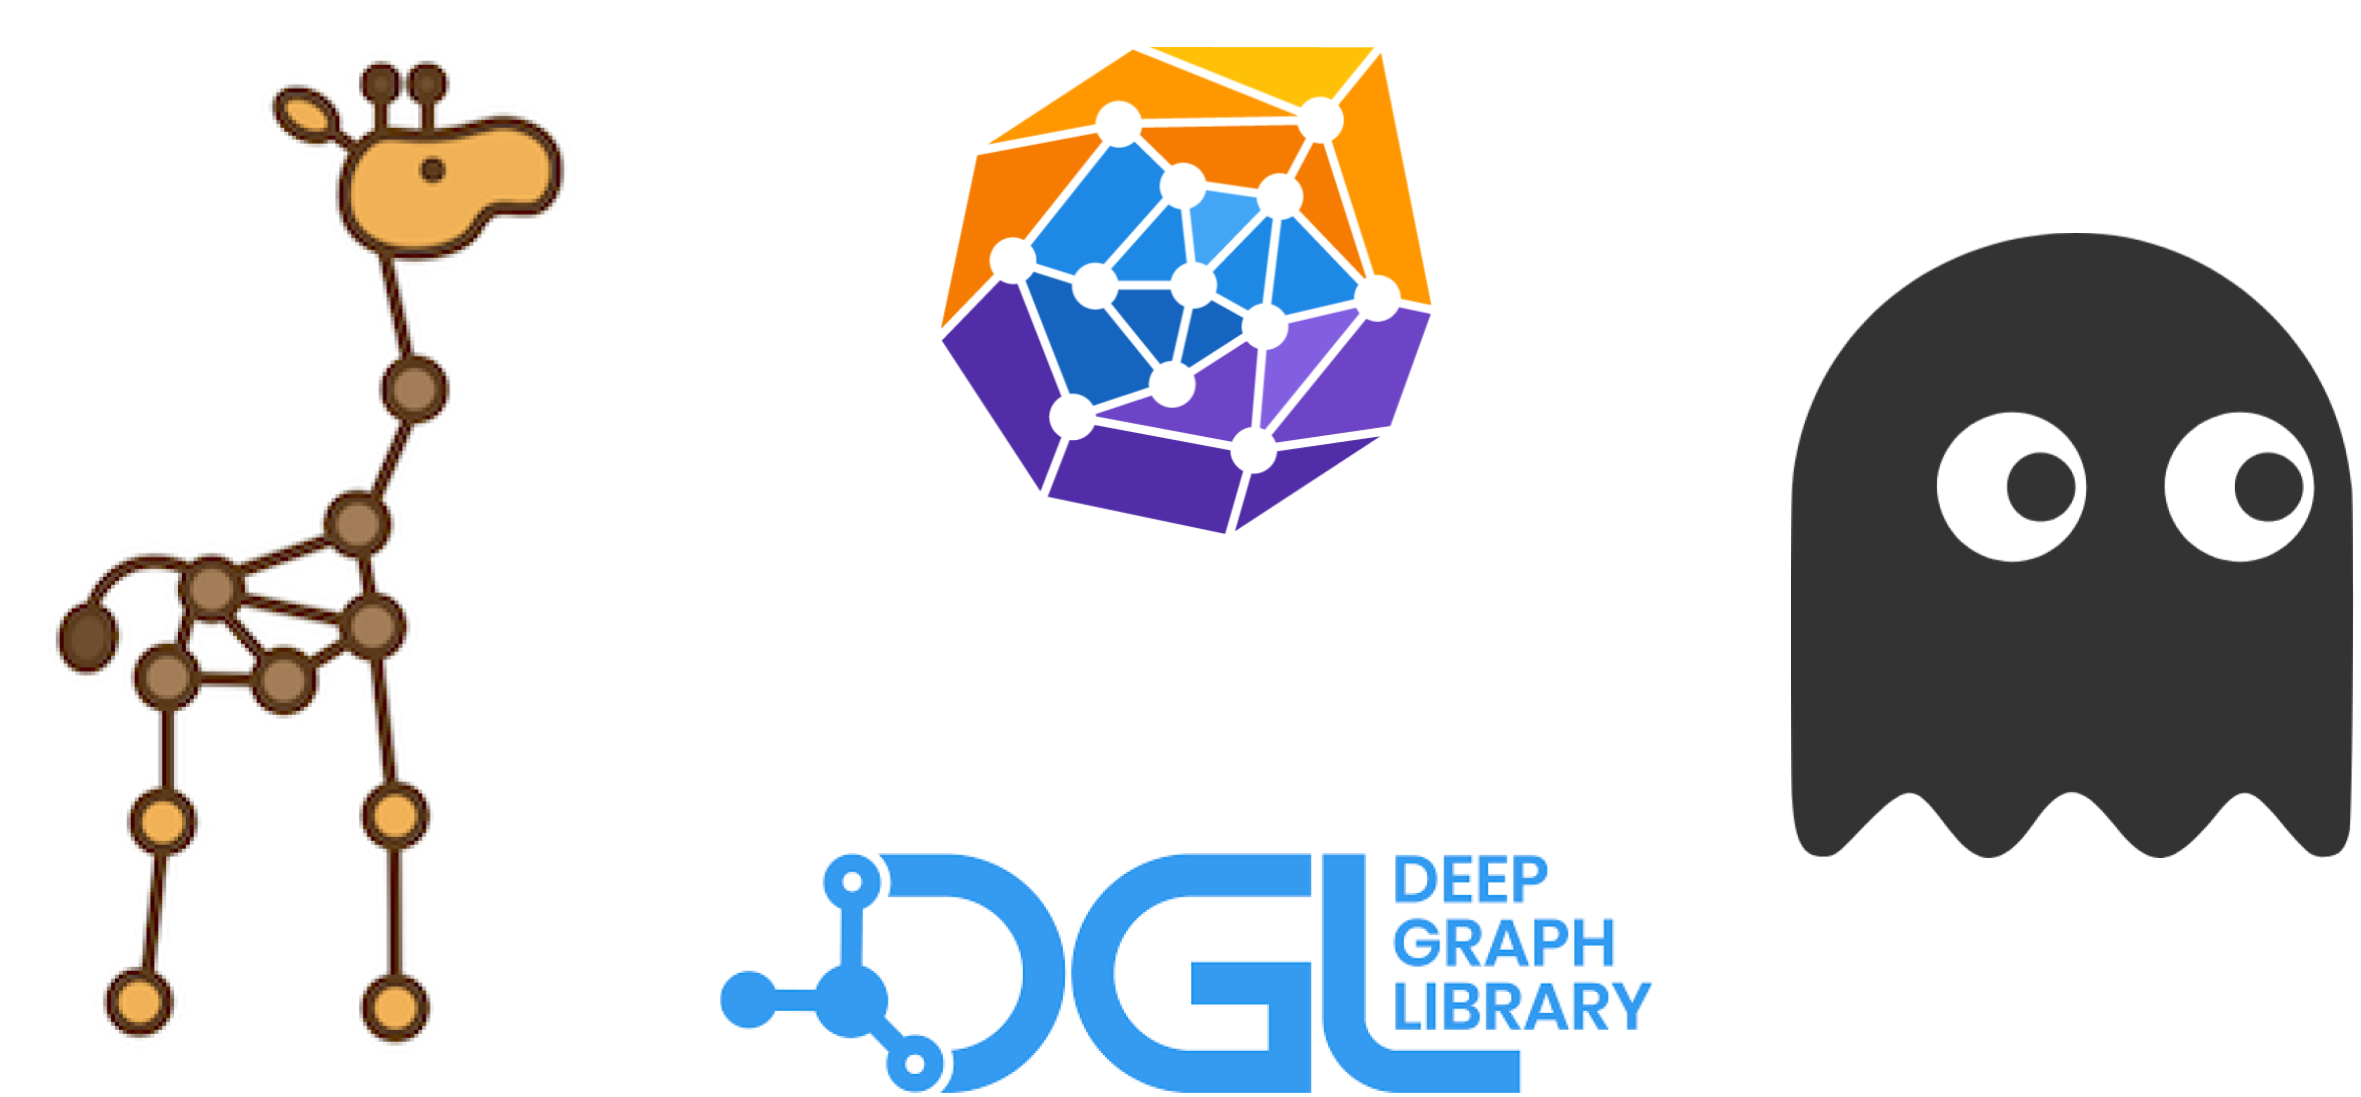

1. **Jraph** - https://github.com/deepmind/jraph
2. PyTorch Geometric - https://pytorch-geometric.readthedocs.io/en/latest/
3. Deep Graph LIbrary - https://docs.dgl.ai/
4. Spektral - https://graphneural.network/

Many models checked into Jax-MD have followed the formalisms for graph neural networks from **Jraph**, centered around the **GraphsTuple** object.

#### GraphsTuple
1. Nodes - [n_nodes, node feature dimension]
2. Edges - [n_edges, edge feature dimension]
3. Receivers - [n_edges]
4. Senders - [n_edges]
5. Globals
6. Number of nodes (n_nodes)
7. Number of edges (n_edges)

#### Nodes and edges can provide chemical information

- Node features include embeddings of the atom type. Additional details could be electronegativity, preferred oxidation state, charge, covalent radius, MatMiner (https://hackingmaterials.lbl.gov/matminer/matminer.utils.html), ...

- Edge features provide connectivity details including the distance or interaction-specific parameters

#### Graph connectivity is defined by receivers, senders
- n_node, n_edges allow for efficient sparse operators (segment_sum, segment_mean)

#### Additional Details


This framework comes with a number of convenient operations. We will not discuss these in significant detail today but feel free to reach out to us with questions.

1. Constant shape operations via padding
2. Batching graph computations

## Section 2: Graph Neural Networks

Let's now turn our attention to graph neural networks, where want to turn an inputted graph (as defined above) into a relevant prediction.

The first step is to consider how to encode our input graphs. Let's assume we have some embedding for the atom types (either to be learned or from prior work) and also encode edge distances via some embedding functions. Common approaches for edges are to use Bessel or Gaussian embeddings.

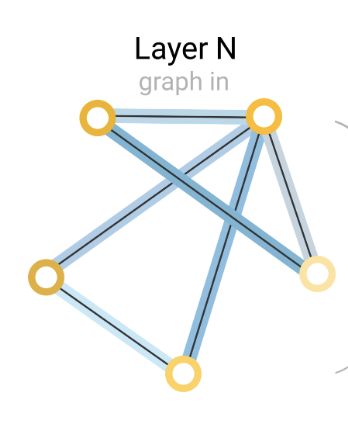

### (I) Message Passing Neural Networks (Gilmer et al. 2017)

For the rest of this tutorial, we will focus on a general framework known as message passing. Let $h_v^t$ be the representation of node $v$ at interaction layer $t$ (i.e. the base representation discussed above will be $t=0$). Then, we can define a message to node $v$ as $$m_v^{t+1} = \underbrace{\sum_{w \in N(v)}}_{\text{sum over neighbors}} \underbrace{M_t}_{\text{learned transform}} \underbrace{(h_v^t, h_w^t, e_{vw})}_{\text{nodes and edge features}}$$

and the update to the node representation is given by 

$$h_v^{t+1} = \underbrace{U_t}_{\text{learned transform}} \underbrace{(h_v^t, m_v^{t+1})}_{\text{previous and message}}$$

Note, many other strategies to process representations and interactions have been proposed. The specific details are less important than noting that at each layer, nodes are updated via their local nieghborhood.

Interactions are often repeated for multiple time steps (i.e. $t \geq 3$). In this way, information flows through the graph and at each time step $t$, nodes can receive information from $t$ edges away.

In [ ]:
#@title Information Propagation

fig = plt.figure(figsize=(6, 6))
plt.scatter(positions[1:, 0], positions[1:, 1])
plt.scatter(positions[0, 0], positions[0, 1], color='g')
colors = ['green', 'orange', 'blue']
frontier = [0]

# Quick search algorithm
visited = set()
for step in range(len(colors)):
  next_frontier = []
  step_labeled = False
  for f in frontier:
    for index, d in enumerate(distances[f]):
      if f != index and d < threshold:
        if f not in visited and index not in visited:
          next_frontier.append(index)
          plt.plot(
              [positions[f, 0], positions[index, 0]], 
              [positions[f, 1], positions[index, 1]],
              color=colors[step], linestyle='--',
              label=f'{step} step' if not step_labeled else ""
          )
          step_labeled = True
    visited.add(f)
  frontier = next_frontier

plt.title("Local Information Propagating in Graph Networks")
plt.xlim(-1, box_size + 1)
plt.ylim(-1, box_size + 1)
plt.show()

### (II) Output

Various strategies can be used to produce an output prediction and optimal approaches often depend on the problem at hand. For now, let's just assume that the output is a permutation-invariant aggregation of the nodes (e.g. via sum / mean) that is then projected to the dimension of interest.

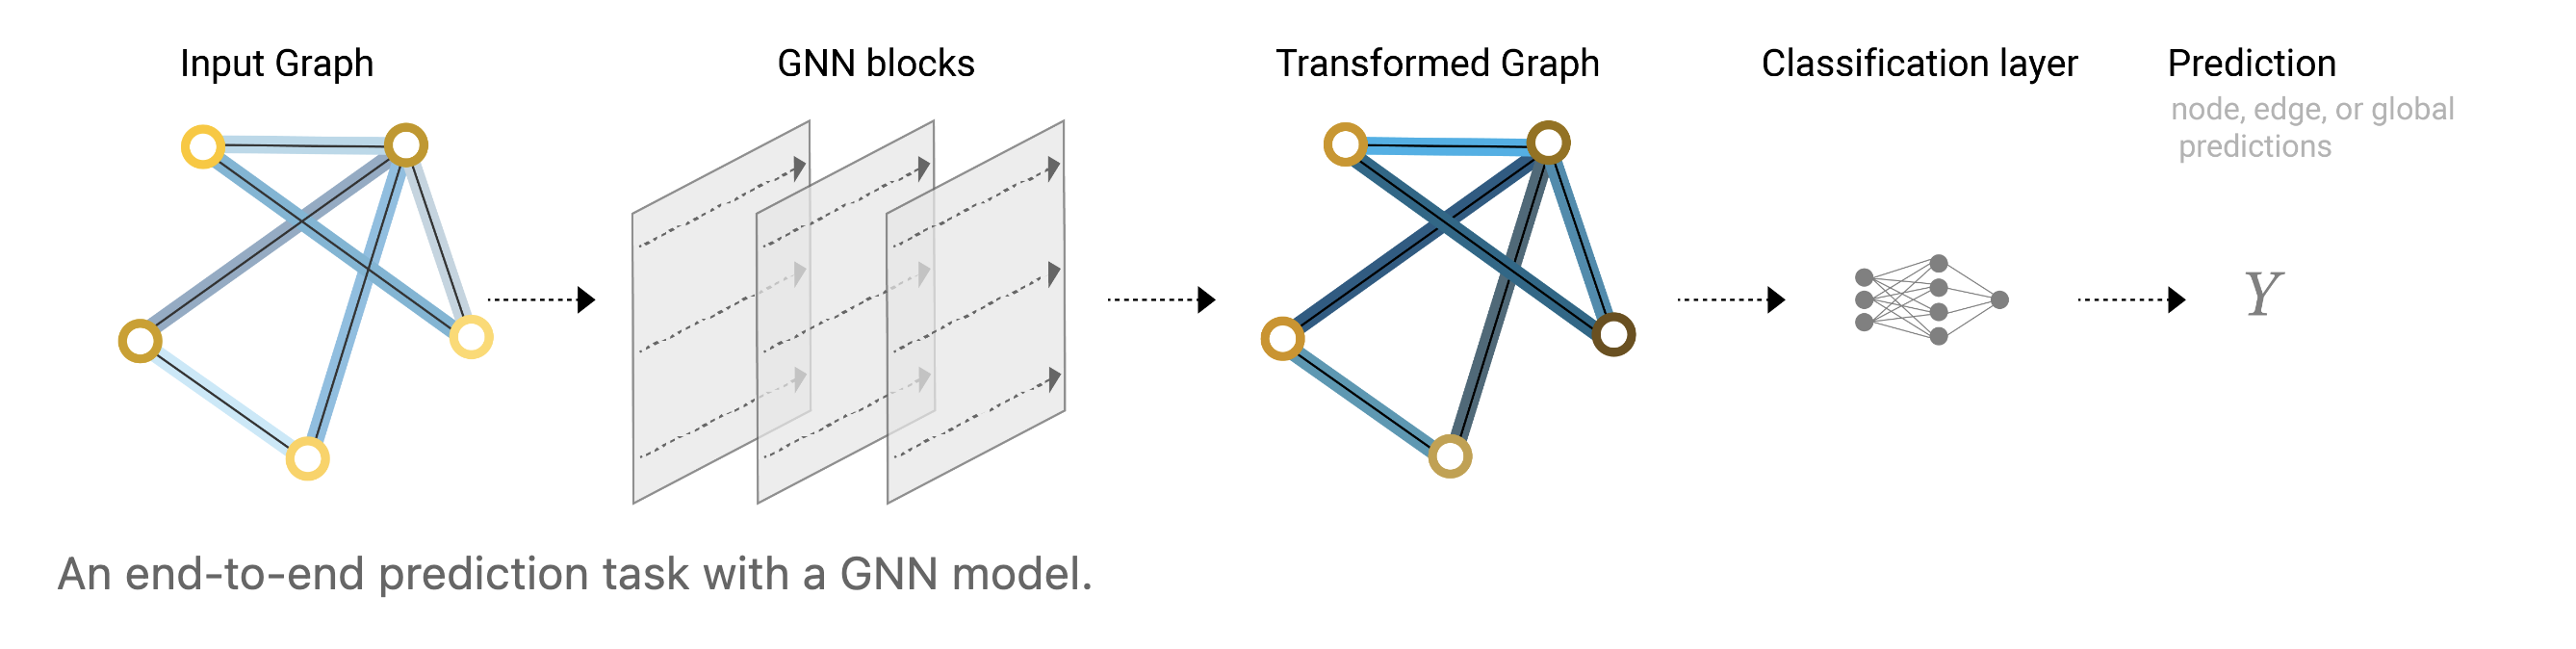

### (III) Example in Jax MD

In [ ]:
from jax_md import energy

#@title Let's ignore the specifics for now.
train = read_lipo('lipo_small/train.msgpack')
test = read_lipo('lipo_small/test.msgpack')

# Atomic numbers
Li = 3
O = 8
P = 15

# Masses in AMU
Li_mass = 6.941
P_mass = 30.9738
O_mass = 15.999

atom_z = jnp.argmax(train['atoms'], axis=-1) + 1
masses = (atom_z == Li) * Li_mass + (atom_z == O) * O_mass + (atom_z == P) * P_mass

box = test['box']
displacement, shift = space.periodic_general(box)

neighbor_list, energy_fn = energy.load_gnome_neighbor_list(
    displacement, None, 'lipo_small/model', atoms=test['atoms'], 
    fractional_coordinates=True,
    disable_cell_list=True)

nbrs = neighbor_list.allocate(test['position'][0])

# Use JAX decorators for just-in-time (jit) compilation and to vectorize commands (vmap)
@jit
@vmap
def batch_energy(position):
  _nbrs = nbrs.update(position)
  return energy_fn(position, _nbrs)

In [ ]:
# We have defined:
#.   test: a dictionary containing positions
#.   batch_energy: a function over positions which computes energies

# Evaluate the energy over the whole test set.
energies = batch_energy(test['position'])

In [ ]:
plt.plot(test['energy'], energies, 'o')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.title('Graph Network Performane on Energy Prediction Task')
plt.show()

## Section 3: Invariance vs Equivariance

Consider the following decision problem.

In [ ]:
# Directly from E3NN Tutorial (https://blondegeek.github.io/e3nn_tutorial/)
from IPython.display import Image
Image('3d_shapes.png', height=250, width=500)

We know that in most physical applications we will want predictions that are:
1. Constant with respect to translations
2. Either constant or equivariant with rotations

Let's now consider the symmetry properties of the neural networks described so far.

The graph networks above only operate via edge distances and atom identities. As neither is modified by translation nor rotation, all outputs will be invariant to the input representation. While a reasonable assumption for quantities such as energies, many quantities of interest in molecular dynamics are vector or tensor-valued. For example, just consider forces. As the input graph rotates, we would hope that any prediction of forces would rotate as well. This motivates the notion of equivariance:

Mathematically, an equivariant function is defined as a homomorphism between two $G$-sets, i.e. $$f : X \rightarrow Y \quad f(g \cdot x) = g \cdot f(x) \quad \forall g \in G \quad \forall x \in X$$

Intuitively, we will work with the space of rotations in 3D (i.e. SO(3)).

The idea here is that our input representations and outputs will be in 3D and should operate by the same rotation matrix. So define a rotation $\pi$; we would like our neural networks to generate predictions such that $$f(\pi \cdot x) = \pi \cdot f(x)$$

#### e3nn-jax: Euclidean Neural Networks

Graph neural networks that obey such rotation equivariance have been designed; in JAX-MD, we follow the frameworks and utilize the tooling developed by e3nn (https://arxiv.org/pdf/2207.09453.pdf). Before diving into applications, we will try to give a *BRIEF* overview of core concepts but full motivations and explanations are left to the references.

#### Definitions:

**Representations:** A function $$D: G \rightarrow \mathbb{R}^{d \times d}$$ that maps each elements of a group to a $d \times d$ matrix is a representation if it follows the structure of the group $D(e) = 1, D(ab) = D(a)D(b)$.

**Irreducible Representations:** A representation that does not contain a smaller representation.

**Irreps of SO(3)** Irreducible representations of SO(3) are indexed by $l=0, 1, 2, \dots$ and each is of dimension $2l+1$. 
- $l=0$ are scalars
- $l=1$ are vectors
- $l\geq 2$ are higher-order tensors

Example, a 3x3 symmetric Cartesian matrix has 6 degrees of freedom and can be represented as the sum of the trace ($l=0$) and the symmetric traceless components ($l=2$)

In e3nn notation, $$\underbrace{5}_{\text{number}} \times \underbrace{1}_{\text{index}} \enspace \underbrace{e}_{\text{parity}}$$



In [ ]:
# Verifying the Irreps have the appropriate dimension
for l in range(5):
  print(f"l={l}, {e3nn.Irreps(f'1x{l}e').dim} components")

In [ ]:
# Example of how Irreps are combined
print(f"A symmetric Cartesian matrix has {e3nn.Irreps('1x0e+1x2e').dim} degrees of freedom")

**Spherical Harmonics** Functions from unit sphere $Y^l$ to the irreducible representation $D^l$. Notable, each $Y^l$ is equivariant to $SO(3)$ with respect to the irredubile representation of the same order.

In [ ]:
#@title Sphearical Harmonic Plotting Utilities

# Directly from e3nn Tutorial (https://blondegeek.github.io/e3nn_tutorial/)
# With minor modification to convert to JAX
import plotly.graph_objects as go
import math

cmap_bwr = [[0, 'rgb(0,50,255)'], [0.5, 'rgb(200,200,200)'], [1, 'rgb(255,50,0)']]
axis = dict(
    showbackground=True,
    showticklabels=False,
    showgrid=True,
    zeroline=True,
    title='',
    nticks=3,
)

layout = dict(
    width=690,
    height=160,
    scene=dict(
        xaxis=dict(
            **axis,
            range=[-8, 8]
        ),
        yaxis=dict(
            **axis,
            range=[-2, 2]
        ),
        zaxis=dict(
            **axis,
            range=[-2, 2]
        ),
        aspectmode='manual',
        aspectratio=dict(x=8, y=2, z=2),
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=0, y=-5, z=5),
            projection=dict(type='orthographic'),
        ),
    ),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    margin=dict(l=0, r=0, t=0, b=0)
)


def trace(r, f, c, radial_abs=True):
    if radial_abs:
        a = jnp.abs(f)
    else:
        a = 1
    return dict(
        x=a * r[..., 0] + c[0],
        y=a * r[..., 1] + c[1],
        z=a * r[..., 2] + c[2],
        surfacecolor=f
    )

def s2_grid():
    betas = jnp.linspace(0, math.pi, 40)
    alphas = jnp.linspace(0, 2 * math.pi, 80)
    beta, alpha = jnp.meshgrid(betas, alphas, indexing='ij')
    return e3nn.angles_to_xyz(alpha, beta)

def plot(data, radial_abs=True):
    r = s2_grid()
    n = data.shape[-1]
    traces = [
        trace(r, data[..., i], np.array([2.0 * i - (n - 1.0), 0.0, 0.0]), radial_abs=radial_abs)
        for i in range(n)
    ]
    cmax = max(list(jnp.max(jnp.abs(d['surfacecolor'])) for d in traces))
    cmax = float(cmax)
    # print(traces)
    traces = [go.Surface(**d, colorscale=cmap_bwr, cmin=-cmax, cmax=cmax) for d in traces]
    fig = go.Figure(data=traces, layout=layout)
    fig.show()

In [ ]:
r = s2_grid()
plot(r, radial_abs=False)

In [ ]:
r = s2_grid()
plot(r, radial_abs=True)

In [ ]:
# Directly from e3nn Tutorial (https://blondegeek.github.io/e3nn_tutorial/)
from IPython.display import Image
Image('spherical_harmonics.png', height=400, width=800)

**Tensor Product** Equivalent of multiplication for higher order values of $l$. This operation is bilinear, equivariant, and can be used to combined representations of various $l$ via independent operation paths.

In [ ]:
# Directly from e3nn Tutorial (https://blondegeek.github.io/e3nn_tutorial/)
from IPython.display import Image
Image('operators.png', height=400, width=800)

In [ ]:
# From e3nn documentation (https://docs.e3nn.org/en/stable/api/o3/o3_tp.html)
from IPython.display import Image
Image('paths.png', height=400, width=400)

#### Equivariant Graph Networks

Equivariant graph neural networks have risen in popularity in the past few years. Rather than only embedding edges as functions of the distance (scalar), edges are now also represented by associated spherical harmonics which provide directional information.

Notably, this allows the equivariant graph networks to make use of additional information that was otherwise unavailable in the graph networks previously described. For example, consider the interaction of two $l=1$ vectors. One of the paths in the tensor product will consider the dot product of these two vectors, providing angular information that was otherwise unavailable to the network with only distances.

#### Design Principles of Equivariant Networks

- Stacked equivariant layers provide equivariant outputs
- Gradients of equivariant layers outputting scalars provide equivariant gradients

#### Nequip

Nequip is one such equivariant network loaded into Jax-MD. Designed by Batzner et al. (https://arxiv.org/abs/2101.03164), this network has achieved state-of-the-art results on a number of molecular dynamics tasks. In the rest of this tutorial, we will ignore some of the specifics of the network design and architecture in favor of the capabilities of Jax-MD with these neural networks.

## Section 4: Graph Neural Networks in Jax-MD

With the foundations of (equivariant) graph networks, let's see how these models can be used to understand dynamic properties of materials. In particular, we will explore Lithium Phosphate amorphous glass formation with composition $\text{Li}_4 \text{P}_2 \text{O}_7$. This material is of interest as its associated family has yielded many promising solid electrolytes for Li-batteries. 

In this example, we assume we have data from molten structure $T=3000K$ for training, and predictions will be tested at signifcantly lower temperatures of $T=600K$.

The associated simulation and model are small-scale experiments, meant to fit on GPUs available in colab. We refer to the original Nequip paper for full-scale results: https://arxiv.org/pdf/2101.03164.pdf.

In [ ]:
#@title JAX MD imports
from jax_md.colab_tools import renderer
from jax_md import space
from jax_md import energy
from jax_md import simulate
from jax_md import quantity
from jax_md.nn import util as nn_util

### Data Analysis using Jax-MD

Let's start by loading and looking at some training and testing data.

In [ ]:
frame_rate = 5 #@param {type:"integer"}

In [ ]:
train = read_lipo('lipo_small/train.msgpack')
test = read_lipo('lipo_small/test.msgpack')

# Atomic numbers
Li = 3
O = 8
P = 15

# Masses in AMU
Li_mass = 6.941
P_mass = 30.9738
O_mass = 15.999

atom_z = jnp.argmax(train['atoms'], axis=-1) + 1
masses = (atom_z == Li) * Li_mass + (atom_z == O) * O_mass + (atom_z == P) * P_mass

The colab-based renderer can be used to visualize the particle positions over many time steps.

In [ ]:
# Training data comes from a high temperature melt.
print("Train Data Visualization.")
box_size = jnp.max(train['box'])
renderer.render(
    box_size,
    renderer.Sphere(space.transform(train['box'], train['position'])),
    # Limit the frame rate for easier visualization
    frame_rate=frame_rate)

In [ ]:
# Testing data comes from a low temperature quench.
print("Test Data Visualization.")
box = test['box']
box_size = jnp.max(box)
renderer.render(
    box_size, 
    renderer.Sphere(space.transform(box, test['position'])),
    frame_rate=frame_rate)

At equivalent frame rates, the difference in temperature is apparent between the two data sets. 

#### Loading in Nequip Models

For convenience, we have already imported some of the popular graph neural network architectures into JAX-MD. 

Built-in functionality such as neighborlists can significantly speed up simulations over multiple time steps.

In [ ]:
box = test['box']
displacement, shift = space.periodic_general(box)

In [ ]:
neighbor_list, energy_fn = energy.load_gnome_neighbor_list(
    displacement, None, 'lipo_small/model', atoms=test['atoms'], 
    fractional_coordinates=True,
    disable_cell_list=True)

#### Evaluating models on *unseen* test data.

In [ ]:
nbrs = neighbor_list.allocate(test['position'][0])

In [ ]:
# Use JAX decorators for just-in-time (jit) compilation and to vectorize commands (vmap)
@jit
@vmap
def batch_energy(position):
  _nbrs = nbrs.update(position)
  return energy_fn(position, _nbrs)

In [ ]:
# Evaluate the energy over the whole test set.
energies = batch_energy(test['position'])

In [ ]:
plt.plot(test['energy'], energies, 'o')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.title('Graph Network Performane on Energy Prediction Task')
plt.show()

In [ ]:
# Evaluate force on a single snapshot.
force_fn = jit(quantity.force(energy_fn))
f = force_fn(test['position'][0], nbrs)

In [ ]:
plt.plot(test['force'][0].reshape((-1,)), f.reshape((-1,)), 'o')
plt.xlabel('True Force')
plt.ylabel('Predicted Force')
plt.title('Graph Network Performane on Force Prediction Task')
plt.show()

#### Minimization via Machine Learned Potentials

Similar to other potentials discussed earlier in the tutorial, machine learned interatomic potentials can be combined with minimization strategies already available in JAX MD.

In [ ]:
from jax_md import minimize
from jax import lax

In [ ]:
# Create an initializer and update function for fire descent (Bitzek et al., 2006)
init_fn, step_fn = minimize.fire_descent(
    energy_fn, shift, dt_start=1e-2, dt_max=4e-2)

In [ ]:
state = init_fn(test['position'][0], neighbor=nbrs)

# A simulation step consists of a minimization step via FIRE and updating neighborlists
def sim(i, state_nbrs_energies):
  state, nbrs, energies = state_nbrs_energies
  energies = energies.at[i].set(energy_fn(state.position, nbrs))
  state = step_fn(state, neighbor=nbrs)
  nbrs = nbrs.update(state.position)
  return state, nbrs, energies

min_steps = 10 #@param {type:"integer"}
energies = jnp.zeros((min_steps,))

# Utilize lax.fori_loop for improved tracing and optimization
state, nbrs, energies = lax.fori_loop(0, min_steps, sim, (state, nbrs, energies))

In [ ]:
plt.plot(energies)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.title('Minimization Trajectory')
plt.show()

In [ ]:
from jax_md import quantity
quantity.stress(energy_fn, state.position, box, neighbor=nbrs)

In [ ]:
# This cell takes a while to run, but shows how machine learned potentials plug
# into other jax md utilities.

# from jax_md import elasticity
# jit(elasticity.athermal_moduli(energy_fn))(state.position, box, neighbor=nbrs)

### Simulations with Machine Learned Potentials

In [ ]:
from jax_md import simulate

In [ ]:
# Unit system such that eV, atomic mass units, and angstrom are 1.
kb = 8.61733362e-5        # boltzmann constant in units of eV/K
fs = 0.09822693530999717  # femtoseconds in units of mass, energy, length == 1

dt = 2 * fs
kT = 300 * kb

init_fn, step_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt=dt, kT=kT)

In [ ]:
from jax import random
key = random.PRNGKey(0)
state = init_fn(key, state.position, mass=masses, neighbor=nbrs)

In [ ]:
steps = 1000  #@param {type:"integer"}
steps_per_write = 100  #@param {type:"integer"}
writes = steps // steps_per_write
n = len(state.position)

data = {
    'energy': jnp.zeros((writes,)),
    'temperature': jnp.zeros((writes,)),
    'position': jnp.zeros((writes, n, 3))
}

@jit
def sim(i, state_nbrs_data):
  state, nbrs, data = state_nbrs_data

  data['energy'] = data['energy'].at[i].set(energy_fn(state.position, nbrs))
  data['temperature'] = data['temperature'].at[i].set(simulate.temperature(state))
  data['position'] = data['position'].at[i].set(space.transform(box, state.position))
  
  def inner_fn(j, state_nbrs):
    state, nbrs = state_nbrs
    state = step_fn(state, neighbor=nbrs)
    nbrs = nbrs.update(state.position)
    return state, nbrs

  state, nbrs = lax.fori_loop(0, steps_per_write, inner_fn, (state, nbrs))

  return state, nbrs, data

In [ ]:
state, nbrs, data = lax.fori_loop(0, writes, sim, (state, nbrs, data))

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(data['temperature'] / kb)
plt.xlabel('Write Index')
plt.ylabel('Normalized Temperature')
plt.subplot(1, 2, 2)
plt.plot(data['energy'])
plt.xlabel('Write Index')
plt.ylabel('Energy')

In [ ]:
renderer.render(box_size, renderer.Sphere(data['position']), frame_rate=frame_rate)

## Section 5: Training a neural network

Thanks for listening so far in this talk!

If you are as excited as we are about machine learning potentials for JAX-MD, we have also built functionality to train and use your own neural network potentials.

These cells are (highly!) recommended to run on GPUs to ensure appropriate performance. 

In [ ]:
from jax_md.nn import nequip

# Design a Nequip architecture
config = nequip.default_config()
# Spherical harmonic representations
config.sh_irreps = '1x0e + 1x1e'
# Hidden representation representations
config.hidden_irreps = '32x0e + 4x1e'
config.radial_net_n_hidden = 16
# Total number of graph net iterations
config.graph_net_steps = 3

# Dataset shift (average) and scale (std deviation)
config.shift = -5.73317
config.scale = 0.030554

config.n_neighbors = 10.
config.scalar_mlp_std = 4.

In [ ]:
neighbor_list, init_fn, energy_fn = energy.nequip_neighbor_list(
    displacement, None, config, atoms=test['atoms'], 
    fractional_coordinates=True,
    disable_cell_list=True)

In [ ]:
params = init_fn(key, state.position, nbrs)

In [ ]:
from jax import grad

def energy_and_nbrs(params, box, position):
  # Updates neighbors lists before computing the energy
  _nbrs = nbrs.update(position, box=box)
  return energy_fn(params, position, _nbrs, box=box)

def energy_loss_fn(params, box, position, energy):
  # Energies are batched over multiple particle positions
  E = vmap(energy_and_nbrs, (None, None, 0))
  predicted_energy = E(params, box, position)
  return jnp.mean((predicted_energy - energy) ** 2)

def force_loss_fn(params, box, position, force):
  # We want the gradient with respect to the position, not the parameters or box.
  F = vmap(grad(energy_and_nbrs, argnums=2), (None, None, 0))
  return jnp.mean((F(params, box, position) + force) ** 2)

@jit
def loss_fn(params, box, position, energy, force):
  # A common optimization is to weight these loss functions to energies
  # and forcess are learned appropriately
  return (energy_loss_fn(params, box, position, energy) + 
          force_loss_fn(params, box, position, force))

Take a few steps of gradient descent.

In [ ]:
batch_size = 10 #@param {type:"integer"}
n = len(train['position'][1])

train_box = train['box']
train_position = train['position'].reshape((-1, batch_size, n, 3))
train_energy = train['energy'].reshape((-1, batch_size,))
train_force = train['force'].reshape((-1, batch_size, n, 3))

test_box = test['box']
test_position = test['position'].reshape((-1, batch_size, n, 3))
test_energy = test['energy'].reshape((-1, batch_size,))
test_force = test['force'].reshape((-1, batch_size, n, 3))

In [ ]:
import optax

# Initialize the optimizer state
opt = optax.adam(5e-3)
opt_state = opt.init(params)

@jit
def update(params, opt_state, box, position, energy, force):
  grad_fn = grad(loss_fn)
  # Update the step based on gradient information
  updates, opt_state = opt.update(
      grad_fn(params, box, position, energy, force), opt_state)
  return optax.apply_updates(params, updates), opt_state

# Iterate through training data (epochs)
for i in ProgressIter(range(100)):
  if i % 10 == 0:
    print(f'Epoch {i}; Train Loss: {loss_fn(params, train_box, train_position[0], train_energy[0], train_force[0])}. '
          f'Test Loss: {loss_fn(params, test_box, test_position[0], test_energy[0], test_force[0])}')
  
  # Iterate over minibatches of data
  for p, e, f in zip(train_position, train_energy, train_force):
    params, opt_state = update(params, opt_state, train_box, p, e, f)

In [ ]:
from functools import partial
E = partial(energy_and_nbrs, params, test_box)

In [ ]:
#@title Plot Predicted Energies
predicted_Es = vmap(E)(test['position'])
test_Es = test['energy']
plt.plot(test_Es, predicted_Es, 'o')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.title('Energy Predictions of Trained Model')
plt.show()

In [ ]:
#@title Plot Predicted Forces
F = quantity.force(E)
predicted_Fs = F(test['position'][1])
test_Fs = test['force']

plt.plot(test_Fs[1].reshape((-1,)), predicted_Fs.reshape((-1,)), 'o')
plt.xlabel('True Force')
plt.ylabel('Predicted Force')
plt.title('Force Predictions of Trained Model')
plt.show()

## Section 6: Looking forward

JAX-MD hopes to continue to support machine learned potentials for atomistic systems. Efforts are in progress to introduce other popular equivariant models and support large-scale machine learned potentials.